# Model Explainablity

In [1]:
import torch
import pandas as pd
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [2]:
import os 
import sys

sys.path.append(os.path.abspath(os.path.join("..","data")))

from load_data import load_hatexplain

In [3]:
model_path = "../models/distilbert/final_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path,output_attentions=True)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

# Human Rationales

In [5]:
dataset = load_hatexplain()
test_data = dataset["test"]

In [20]:
records = []

for ex in test_data:
    records.append({
        "post_id": ex["id"],
        "tokens": ex["post_tokens"],
        "text": " ".join(ex["post_tokens"]),
        "rationales": ex["rationales"],
        "label": ex["annotators"]["label"]
    })

df = pd.DataFrame(records)
df.head()

,post_id,tokens,text,rationales,label
0,1178610029273976833_twitter,"[<user>, men, can, not, be, raped, can, not, b...",<user> men can not be raped can not be abused ...,[],"[1, 1, 1]"
1,1165785686903009283_twitter,"[<user>, you, are, missing, an, essential, pre...",<user> you are missing an essential premise wh...,[],"[2, 1, 1]"
2,1252707503441313794_twitter,"[<user>, <user>, why, are, you, repeating, you...",<user> <user> why are you repeating yourself a...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, ...","[2, 1, 2]"
3,1103385226921762816_twitter,"[<user>, <user>, well, she, ’, muslim, so, of,...",<user> <user> well she ’ muslim so of course s...,"[[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,...","[0, 0, 0]"
4,1169443635869487105_twitter,"[<user>, lol, not, me, i, don, ’, t, deal, wit...",<user> lol not me i don ’ t deal with bms not ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2, 0, 2]"


In [7]:
def agg_rationales(rationales):
    if not rationales:
        return None
    agg = []
    for i in range(len(rationales[0])):
        count = sum(r[i] for r in rationales)
        agg.append(1 if count >= 2 else 0)
    return agg

df["human_rationale"] = df["rationales"].apply(agg_rationales)

In [8]:
def get_attention_scores(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=160)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    attentions = outputs.attentions[-1]   
    attn = attentions.mean(dim=1)[0]     
    cls_attn = attn[0]                    
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

    return tokens, cls_attn.cpu().numpy()


In [9]:
def visualize_attention(tokens, scores):
    import matplotlib.pyplot as plt
    
    scores = scores / scores.max()
    
    plt.figure(figsize=(14,2))
    plt.bar(range(len(tokens)), scores)
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.title("Model Attention")
    plt.show()

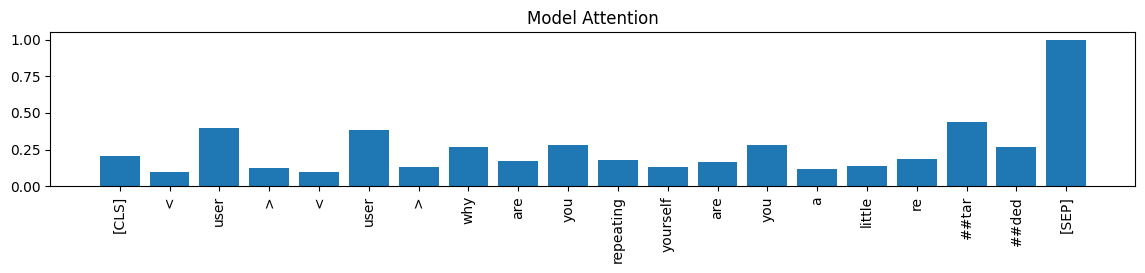

In [10]:
tokens, scores = get_attention_scores(df.iloc[2]["text"])
visualize_attention(tokens, scores)

# Word Level Alignment

In [11]:
def word_level_attention(text, word_rationale):
    words = text.split()
    tokens, scores = get_attention_scores(text)
    
    word_scores = []
    current_word = ""
    current_scores = []

    for tok, score in zip(tokens, scores):
        if tok in ["[CLS]","[SEP]","[PAD]"]:
            continue
        
        tok = tok.replace("##","")
        current_word += tok
        current_scores.append(score)
        
        if current_word in words:
            word_scores.append(np.mean(current_scores))
            current_word = ""
            current_scores = []
    
    L = min(len(word_scores), len(word_rationale))
    return words[:L], word_scores[:L], word_rationale[:L]

In [12]:
sample = df[df["human_rationale"].notnull()].sample(1).iloc[0]

words, model_scores, human = word_level_attention(
    sample["text"],
    sample["human_rationale"]
)

list(zip(words, model_scores, human))


[('<number>', 0.020070922, 0),
 ('to', 0.0064527667, 0),
 ('fulfill', 0.00524394, 0),
 ('this', 0.013252816, 0),
 ('plan', 0.0049463348, 0),
 ('the', 0.027012503, 0),
 ('left', 0.046430793, 0),
 ('is', 0.02487113, 0),
 ('trying', 0.011644671, 0),
 ('to', 0.0109879, 0),
 ('fill', 0.0055447663, 0),
 ('the', 0.009447173, 0),
 ('country', 0.016713552, 0),
 ('with', 0.0044437996, 0),
 ('the', 0.01062127, 0),
 ('3', 0.025464624, 0),
 ('rd', 0.028852923, 0),
 ('world', 0.009499262, 0),
 ('population', 0.006694042, 0),
 ('they', 0.033885352, 0),
 ('are', 0.015589131, 0),
 ('easily', 0.0074409265, 0),
 ('moldible', 0.006408125, 0),
 ('into', 0.0063018496, 0),
 ('revolutionary', 0.025981646, 0),
 ('lumpen', 0.024489108, 0),
 ('combined', 0.022091236, 0),
 ('with', 0.013296021, 0),
 ('home', 0.008176101, 0),
 ('grown', 0.0051494553, 0),
 ('ghetto', 0.03413481, 1),
 ('population', 0.008295318, 0),
 ('they', 0.052582562, 0),
 ('will', 0.040434882, 0),
 ('be', 0.011448083, 0),
 ('a', 0.010641433, 0)

In [13]:
def plot_alignment(words, model_scores, human):
    import matplotlib.pyplot as plt
    
    x = range(len(words))
    
    plt.figure(figsize=(14,4))
    plt.bar(x, model_scores, alpha=0.7, label="Model attention")
    plt.scatter(x, human, color="red", label="Human rationale", s=50)
    
    plt.xticks(x, words, rotation=90)
    plt.legend()
    plt.title("Model vs Human Rationale Alignment")
    plt.show()


# Visual Alignment Plot

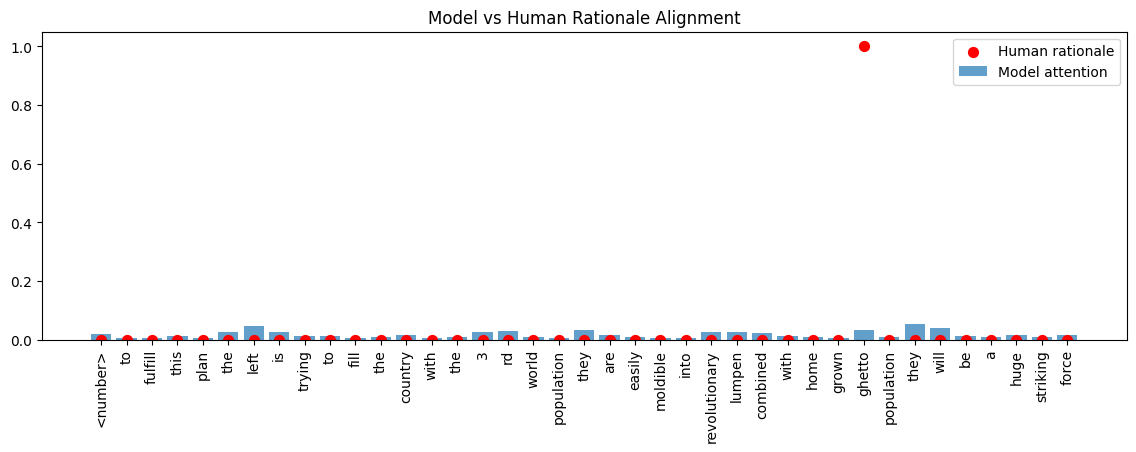

In [14]:
plot_alignment(words, model_scores, human)

## Bias check

In [19]:
bias_tests = [
    "I hate women",
    "I hate men",
    "I hate Muslims",
    "I hate Christians",
    "I hate black people",
    "I hate white people",
    "I hate gamers",
    "I hate politicians"]

for sent in bias_tests:
    tokens, scores = get_attention_scores(sent)
    print("\n->", sent)
    for t, s in zip(tokens, scores):
        if t not in ["[CLS]","[SEP]"]:
            print(t, round(float(s),3))



-> I hate women
i 0.15
hate 0.237
women 0.184

-> I hate men
i 0.149
hate 0.239
men 0.186

-> I hate Muslims
i 0.162
hate 0.167
muslims 0.147

-> I hate Christians
i 0.174
hate 0.213
christians 0.104

-> I hate black people
i 0.17
hate 0.18
black 0.095
people 0.102

-> I hate white people
i 0.171
hate 0.193
white 0.107
people 0.102

-> I hate gamers
i 0.151
hate 0.23
gamer 0.124
##s 0.132

-> I hate politicians
i 0.172
hate 0.267
politicians 0.147


# Takeaways:
- It shows that DistilBERT trained aligns with most human rationale on abusive or slur terms
- Few cases of attention on identity terms independent of abusive context
- Few mislaignments on sarcasm, long range dependencies or ambigious annotations 